# Inferring loads on an Euler Bernoulli beam

Here we look at another linear Gaussian inverse problem, but one with a distributed parameter field and PDE forward model.  More specifically, the inverse problem is to infer the forces acting along a cantilevered beam.

<div><img src="CantileverBeam.png" width="500px" style="padding-bottom:0.5em;"/><br>Image courtesy of wikimedia.org</div>
  


### Formulation:

Let $u(x)$ denote the vertical deflection of the beam and let $m(x)$ denote the vertial force acting on the beam at point $x$ (positive for upwards, negative for downwards).  We assume that the displacement can be well approximated using Euler-Bernoulli beam theory and thus satisfies the PDE
$$
\frac{\partial^2}{\partial x^2}\left[ E(x) \frac{\partial^2 u}{\partial x^2}\right] = m(x),
$$
where $E(x)$ is an effective stiffness that depends both on the beam geometry and material properties.  In this lab, we assume $E(x)$ is constant and $E(x)=10^5$.  However, in future labs, $E(x)$ will also be an inference target. 

For a beam of length $L$, the cantilever boundary conditions take the form
$$
u(x=0) = 0,\quad \left.\frac{\partial u}{\partial x}\right|_{x=0} = 0
$$
and
$$
\left.\frac{\partial^2 u}{\partial x^2}\right|_{x=L} = 0, \quad  \left.\frac{\partial^3 u}{\partial x^3}\right|_{x=L} = 0.
$$
  
Discretizing this PDE with finite differences (or finite elements, etc...), we obtain a linear system of the form
$$
Ku = m,
$$
where $u\in\mathbb{R}^N$ and $m\in\mathbb{R}^N$ are vectors containing approximations of $u(x)$ and $m(x)$ at the finite difference nodes.  

Only $M$ components of the $N$ dimensional vector $u$ are observed.  To account for this, we introduce a sparse matrix $B$ that extracts $M$ unique components of $u$.  Combining this with an additive Gaussian noise model, we obtain  
$$
y = BK^{-1} m + \epsilon,
$$
where $\epsilon \sim N(0,\Sigma_y)$.



## Imports

In [1]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import h5py

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes

## Read discretization and observations

In [2]:
f = h5py.File('FullProblemDefinition.h5','r')
x = np.array( f['/ForwardModel/NodeLocations'] )
K = np.array( f['/ForwardModel/SystemMatrix'] )
B = np.array( f['/Observations/ObservationMatrix'] )
obsData = np.array( f['/Observations/ObservationData'] )

trueLoad = np.array( f['/ForwardModel/Loads'])

numObs = obsData.shape[0]
numPts = x.shape[1]
dim = 1

## Construct components of the likelihood

In [3]:
obsMat = np.linalg.solve(K,B.T).T
noiseCov = 1e-12 * np.eye(numObs)

## Define a Gaussian Process prior

In [4]:
priorVar = 10*10
priorLength = 0.5
priorNu = 3.0/2.0 # must take the form N+1/2 for zero or odd N (i.e., {0,1,3,5,...})

kern1 = ma.MaternKernel(1, 1.0, priorLength, priorNu)
kern2 = ma.ConstantKernel(1, priorVar)
kern = kern1 + kern2

dim =1
coDim = 1 # The dimension of the load field at a single point
mu = ma.ZeroMean(dim,coDim)

priorGP = ma.GaussianProcess(mu,kern)

### Plot prior samples

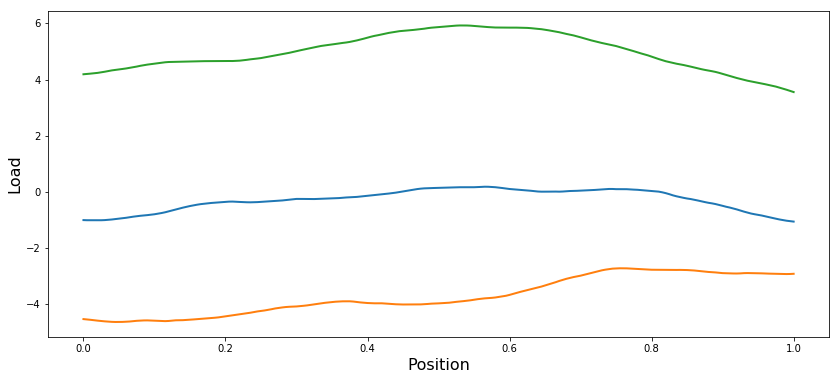

In [5]:
plt.figure(figsize=(14,6))

numSamps = 3
for i in range(numSamps):
    samp = priorGP.Sample(x)
    plt.plot(x[0,:], samp[0,:], linewidth=2)
    
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

### Compute posterior

In [6]:
prior = priorGP.Discretize(x)
post = prior.Condition(obsMat, obsData, noiseCov)

### Plot posterior

In [7]:
postMean = post.GetMean()
postCov = post.GetCovariance()
postStd = np.sqrt(np.diag(postCov))

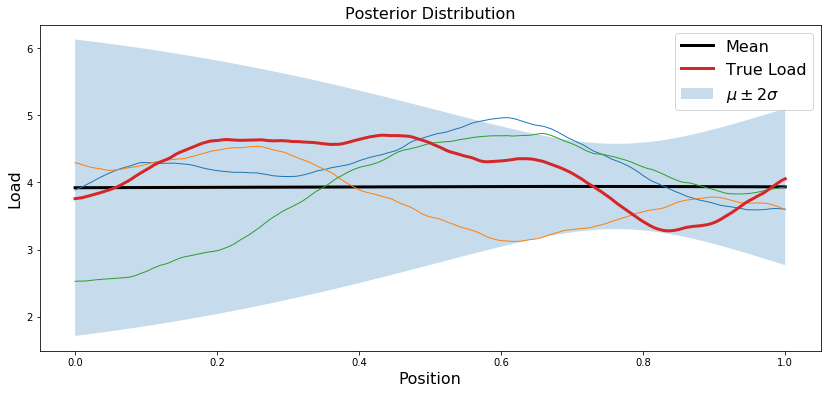

In [8]:
plt.figure(figsize=(14,6))

plt.plot(x.T, postMean, 'k', linewidth=3, label='Mean')

plt.fill_between(x[0,:], postMean+2.0*postStd, postMean-2.0*postStd, alpha=0.25, edgecolor='None', label='$\mu \pm 2\sigma$')

for i in range(numSamps):
    samp = post.Sample()
    plt.plot(x.T, samp.T, linewidth=1)

plt.plot(x.T, trueLoad, linewidth=3, label='True Load')

plt.legend(fontsize=16)
plt.title('Posterior Distribution',fontsize=16)
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

## Incorporate observation of the load sum
Assume you are now given an additional observation: the sum of the load vector $m$.

In [9]:
sumObs = np.array( f['/Observations/LoadSum'] )
sumNoiseVar = 1e-7 * np.ones(1)

In [10]:
obsMatSum = np.ones((1,numPts))
sumPost = post.Condition(obsMatSum, sumObs, sumNoiseVar)

In [11]:
postMean = sumPost.GetMean()
postCov = sumPost.GetCovariance()
postStd = np.sqrt(np.diag(postCov))

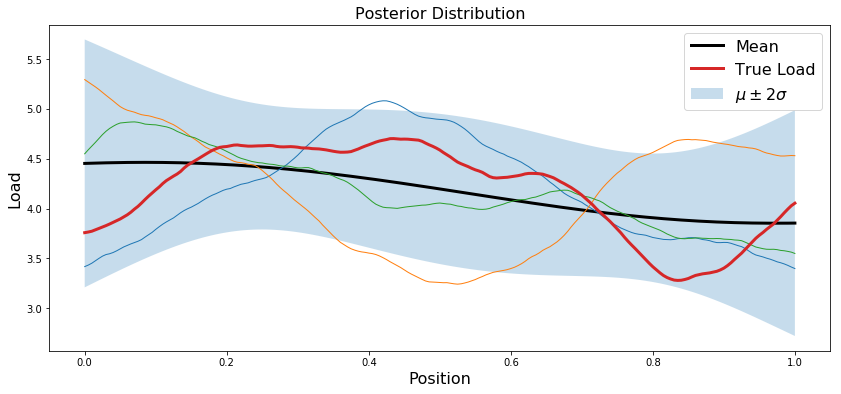

In [12]:
plt.figure(figsize=(14,6))

plt.plot(x.T, postMean, 'k', linewidth=3, label='Mean')

plt.fill_between(x[0,:], postMean+2.0*postStd, postMean-2.0*postStd, alpha=0.25, edgecolor='None', label='$\mu \pm 2\sigma$')

for i in range(numSamps):
    samp = sumPost.Sample()
    plt.plot(x.T, samp.T, linewidth=1)

plt.plot(x.T, trueLoad, linewidth=3, label='True Load')

plt.legend(fontsize=16)
plt.title('Posterior Distribution',fontsize=16)
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

## Incorporate a point observation of the load itself

In [13]:
ptObs = np.array( f['/Observations/LoadPoint'] )

obsMatPt = np.zeros((1,numPts))
obsMatPt[0,-1] = 1
pointNoiseVar = 1e-4 * np.ones(1)

ptPost = sumPost.Condition(obsMatPt, ptObs, sumNoiseVar)


In [14]:
postMean = ptPost.GetMean()
postCov = ptPost.GetCovariance()
postStd = np.sqrt(np.diag(postCov))

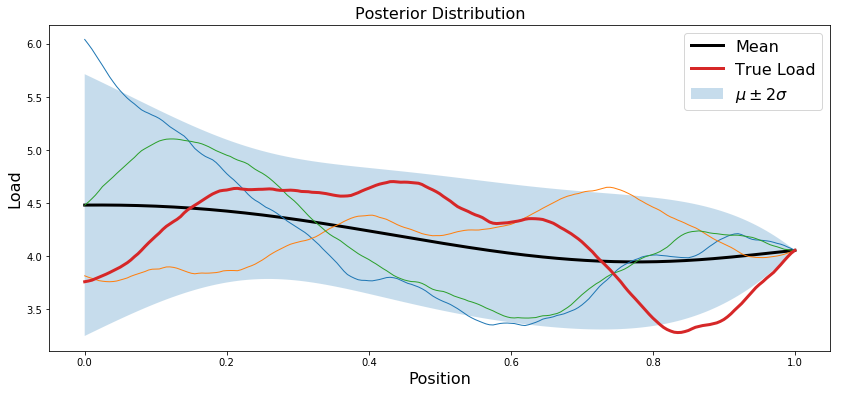

In [15]:
plt.figure(figsize=(14,6))
plt.plot(x.T, postMean, 'k', linewidth=3, label='Mean')

plt.fill_between(x[0,:], postMean+2.0*postStd, postMean-2.0*postStd, alpha=0.25, edgecolor='None', label='$\mu \pm 2\sigma$')

for i in range(numSamps):
    samp = ptPost.Sample()
    plt.plot(x.T, samp.T, linewidth=1)

plt.plot(x.T, trueLoad, linewidth=3, label='True Load')

plt.legend(fontsize=16)
plt.title('Posterior Distribution',fontsize=16)
plt.xlabel('Position',fontsize=16)
plt.ylabel('Load',fontsize=16)
plt.show()

## Analyze low-rank structure

The posterior precision is given by $\Gamma_{pos}^{-1} = H + \Gamma_{pr}^{-1}$, where $H$ is the Hessian of the log-likelihood function.  In this example, $H = A^T\Gamma_{obs}A$


In [16]:
import scipy.linalg as la

### Rank of likelihood Hessian

In [17]:
likelyHess = np.dot( obsMat.T, la.solve(noiseCov, obsMat))

hessVals, _ = la.eigh(likelyHess)
hessVals[hessVals<1e-15] = 1e-15

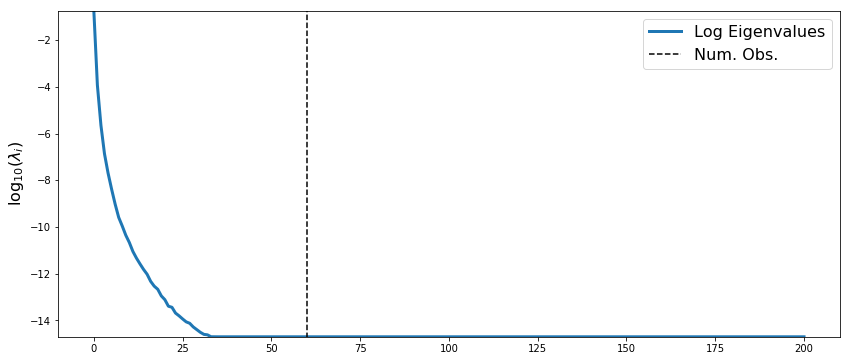

In [18]:
logHessVals = np.log10(hessVals+1e-15)

plt.figure(figsize=(14,6))
plt.plot(logHessVals[::-1], label='Log Eigenvalues', linewidth=3)
plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylabel('$\log_{10}(\lambda_i)$',fontsize=16)

plt.ylim((np.min(logHessVals),np.max(logHessVals)))
plt.legend(fontsize=16)

plt.show()

### Likelihood-Informed Subspace

In [19]:
likelyHess = np.dot( obsMat.T, la.solve(noiseCov, obsMat))
priorPrec = prior.GetPrecision()
postPrec = priorPrec + likelyHess

priorVals, _ = la.eigh(priorPrec)
priorVals[priorVals<1e-15] = 1e-15

postVals, _ = la.eigh(postPrec)
postVals[postVals<1e-15] = 1e-15

lisVals, _ = la.eigh(likelyHess, priorPrec)
lisVals[lisVals<1e-15] = 1e-15

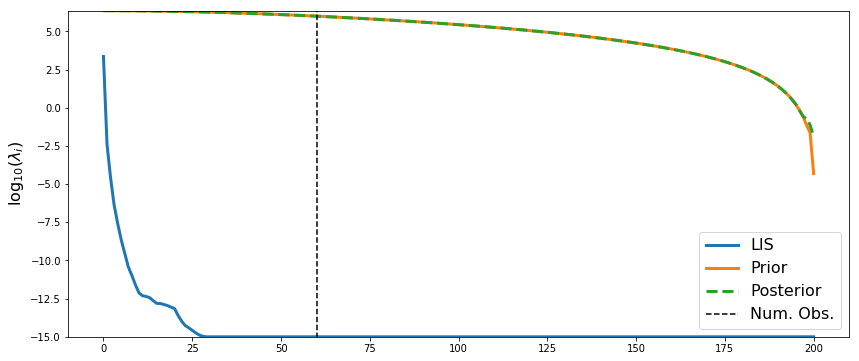

In [20]:
plt.figure(figsize=(14,6))

logLisVals = np.log10(lisVals)
plt.plot(logLisVals[::-1], label='LIS', linewidth=3)

logPriorVals = np.log10(priorVals)
plt.plot(logPriorVals[::-1], label='Prior', linewidth=3)

logPostVals = np.log10(postVals)
plt.plot(logPostVals[::-1], '--', label='Posterior', linewidth=3)

plt.plot([numObs,numObs],[-100,100],'--k',label='Num. Obs.')
plt.ylabel('$\log_{10}(\lambda_i)$',fontsize=16)

plt.ylim((np.min(logLisVals),np.max(logPriorVals)))
plt.legend(fontsize=16)
plt.show()